In [1]:
import pickle,itertools,sys,pdb
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import graphviz
from ultron.factor.genetic.geneticist.genetic import Gentic
import warnings
warnings.filterwarnings("ignore")

In [2]:
## IC 方法
def websim_weighted(factor_data, total_data, factor_sets):
    factor_data = factor_data.copy()
    factor_data = factor_data.reset_index().sort_values(['trade_date','code'])
    #此处ret放的位置不对，仅用于测试例
    factor_data = factor_data.fillna(0)
    score = np.corrcoef(factor_data['transformed'].values, total_data.sort_values(['trade_date','code'])['ret'].values)[0,1]
    return abs(score)


with open('factor_data.pkl','rb') as file2:
    total_data = pickle.load(file2)
    
factor_sets = [i for i in list(set(total_data.columns)) if i not in ['trade_date','code','ret']]
gentic = Gentic(population_size=30, tournament_size = 7, 
                init_depth=(4, 5),
                generations=3, n_jobs = 8, stopping_criteria=100, verbose=0,
                factor_sets = factor_sets,
                fitness=websim_weighted)

gentic.train(total_data=total_data)
result = gentic._run_details

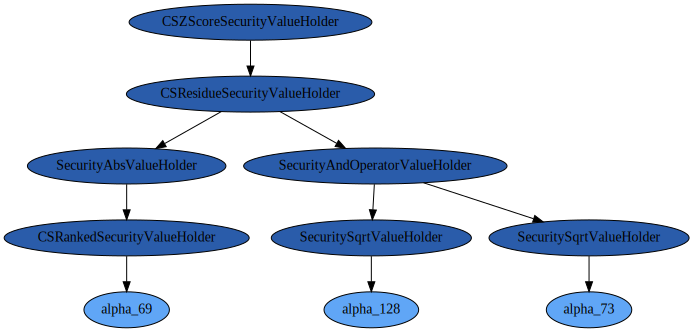

In [3]:
graphviz.Source(result['best_programs'][-1][-1].export_graphviz())

In [4]:
[programs._raw_fitness for programs in result['best_programs'][-1]]

[0.022059503749287227,
 0.022059503749287227,
 0.022059503749287227,
 0.022059503749287227,
 0.022059503749287227,
 0.025745139654465315,
 0.029826384408360104]